In [ ]:
!pip install split-folders
!pip install gdown

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import gdown
import splitfolders
import shutil
from tensorflow.keras.applications import ResNet152
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files

In [ ]:
shutil.rmtree("SkinDisease", ignore_errors=True)
shutil.rmtree("skin_dataset", ignore_errors=True)

In [ ]:
file_id = "1NZTookxlFKAU371O3SW4KG41doDAKZej"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1NZTookxlFKAU371O3SW4KG41doDAKZej
From (redirected): https://drive.google.com/uc?id=1NZTookxlFKAU371O3SW4KG41doDAKZej&confirm=t&uuid=9fc8232f-a445-43e5-810f-6041575b3af5
To: /content/dataset.zip
100%|██████████| 2.14G/2.14G [00:27<00:00, 78.6MB/s]


'dataset.zip'

In [ ]:
!unzip -q dataset.zip -d skin_dataset

In [ ]:
splitfolders.ratio(
    input="skin_dataset",           # Folder hasil unzip
    output="SkinDisease",           # Folder output untuk split
    seed=42,
    ratio=(0.7, 0.3),               # 70% train, 30% test
    move=False                      # Copy, bukan pindah file
)
os.rename("SkinDisease/val", "SkinDisease/test")

Copying files: 37293 files [00:10, 3716.94 files/s]


In [ ]:
train_dir = "SkinDisease/train"
test_dir = "SkinDisease/test"

In [ ]:
def count_images_per_split(split_path):
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            print(f"{cls}: {count}")
            total += count
    print(f"Total: {total}")

print("=== TRAIN ===")
count_images_per_split("SkinDisease/train")
print("\n=== TEST ===")
count_images_per_split("SkinDisease/test")

=== TRAIN ===
Candidiasis: 1205
SkinCancer: 1248
Bullous: 1232
DrugEruption: 1284
Actinic_Keratosis: 1253
Vascular_Tumors: 1233
Acne: 1288
Moles: 1222
Tinea: 1273
Vitiligo: 1250
Eczema: 1273
Warts: 1247
Lichen: 1234
Infestations_Bites: 1229
Sun_Sunlight_Damage: 1210
Vasculitis: 1241
Rosacea: 1220
Seborrh_Keratoses: 1225
Benign_tumors: 1274
Psoriasis: 1253
Lupus: 1202
Total: 26096

=== TEST ===
Candidiasis: 517
SkinCancer: 535
Bullous: 528
DrugEruption: 551
Actinic_Keratosis: 537
Vascular_Tumors: 529
Acne: 552
Moles: 524
Tinea: 546
Vitiligo: 536
Eczema: 546
Warts: 535
Lichen: 530
Infestations_Bites: 528
Sun_Sunlight_Damage: 519
Vasculitis: 533
Rosacea: 524
Seborrh_Keratoses: 526
Benign_tumors: 547
Psoriasis: 538
Lupus: 516
Total: 11197


In [ ]:
classes = [
    "Acne", "Actinic Keratosis", "Benign Tumors", "Bullous", "Candidiasis",
    "Drug Eruption", "Eczema", "Infestations/Bites", "Lichen", "Lupus",
    "Moles", "Psoriasis", "Rosacea", "Seborrheic Keratoses", "Skin Cancer",
    "Sun/Sunlight Damage", "Tinea", "Vascular Tumors", "Vasculitis", "Vitiligo",
    "Warts"
]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 20886 images belonging to 21 classes.
Found 5210 images belonging to 21 classes.
Found 11197 images belonging to 21 classes.


In [ ]:
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {val_generator.samples}")
print(f"Number of testing samples: {test_generator.samples}")

Number of training samples: 20886
Number of validation samples: 5210
Number of testing samples: 11197


In [ ]:
def show_images(generator, classes, num_images=8):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(classes[np.argmax(labels[i])])
        axes[i].axis('off')
    plt.show()

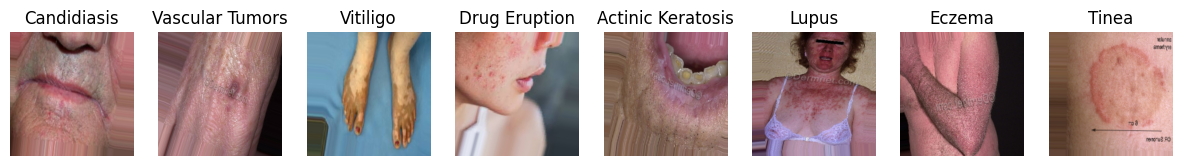

In [ ]:
show_images(train_generator, classes)

In [ ]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = True
# from tensorflow.keras.applications import EfficientNetB1
# base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = True

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    verbose=1,
    restore_best_weights=True,
    #baseline=0.90
)

callbacks = [reduce_lr, checkpoint, early_stopping]

In [ ]:
model = models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 58,900,885 (224.69 MB)

 Trainable params: 58,749,461 (224.11 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.6487 - loss: 1.2735
Epoch 1: val_accuracy improved from -inf to 0.05489, saving model to best_model.h5


653/653 ━━━━━━━━━━━━━━━━━━━━ 773s 938ms/step - accuracy: 0.6488 - loss: 1.2731 - val_accuracy: 0.0549 - val_loss: 3.0766 - learning_rate: 1.0000e-04
Epoch 2/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.7822 - loss: 0.7420
Epoch 2: val_accuracy improved from 0.05489 to 0.72994, saving model to best_model.h5


653/653 ━━━━━━━━━━━━━━━━━━━━ 547s 837ms/step - accuracy: 0.7822 - loss: 0.7420 - val_accuracy: 0.7299 - val_loss: 1.0115 - learning_rate: 1.0000e-04
Epoch 3/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.8151 - loss: 0.6234
Epoch 3: val_accuracy improved from 0.72994 to 0.75585, saving model to best_model.h5


653/653 ━━━━━━━━━━━━━━━━━━━━ 548s 839ms/step - accuracy: 0.8151 - loss: 0.6234 - val_accuracy: 0.7559 - val_loss: 1.0500 - learning_rate: 1.0000e-04
Epoch 4/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8379 - loss: 0.5361
Epoch 4: val_accuracy improved from 0.75585 to 0.77121, saving model to best_model.h5


653/653 ━━━━━━━━━━━━━━━━━━━━ 555s 849ms/step - accuracy: 0.8379 - loss: 0.5361 - val_accuracy: 0.7712 - val_loss: 0.9382 - learning_rate: 1.0000e-04
Epoch 5/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8571 - loss: 0.4786
Epoch 5: val_accuracy did not improve from 0.77121
653/653 ━━━━━━━━━━━━━━━━━━━━ 531s 812ms/step - accuracy: 0.8571 - loss: 0.4786 - val_accuracy: 0.7537 - val_loss: 1.0707 - learning_rate: 1.0000e-04
Epoch 6/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.8670 - loss: 0.4364
Epoch 6: val_accuracy did not improve from 0.77121
653/653 ━━━━━━━━━━━━━━━━━━━━ 531s 812ms/step - accuracy: 0.8670 - loss: 0.4364 - val_accuracy: 0.7656 - val_loss: 1.0282 - learning_rate: 1.0000e-04
Epoch 7/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8871 - loss: 0.3745
Epoch 7: val_accuracy did not improve from 0.77121
653/653 ━━━━━━━━━━━━━━━━━━━━ 530s 811ms/step - accuracy: 0.8871 - loss: 0.3745 - val_accuracy: 0.7436 - val_loss: 1.0666 - learning_rate

653/653 ━━━━━━━━━━━━━━━━━━━━ 569s 870ms/step - accuracy: 0.9333 - loss: 0.2209 - val_accuracy: 0.7893 - val_loss: 1.0909 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 10.


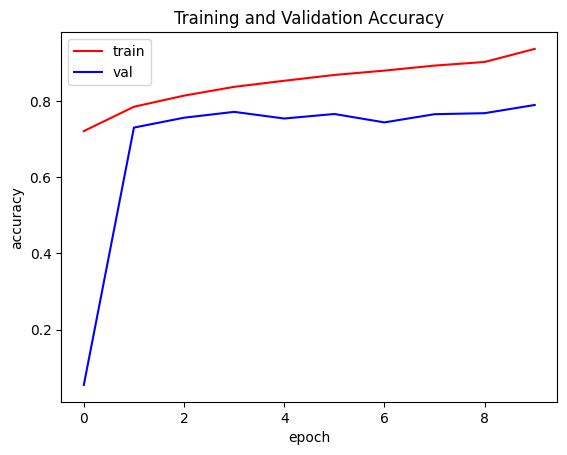

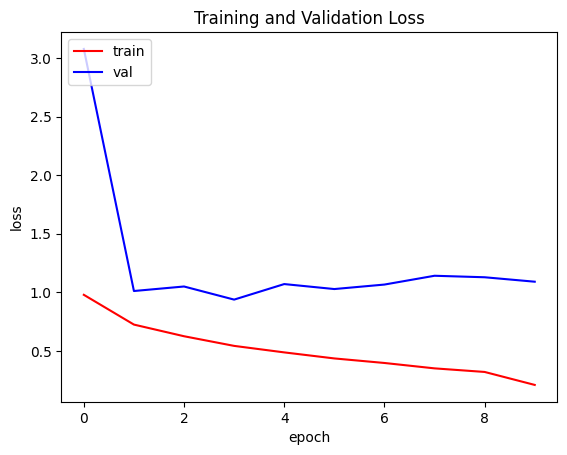

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("resnet_model.h5")
print("Model saved as resnet_model.h5")

In [ ]:
model = tf.keras.models.load_model("best_model.h5")
print("Model loaded successfully")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


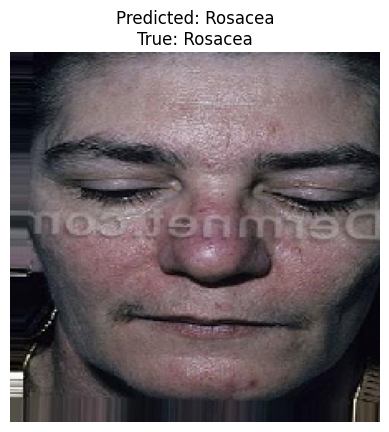

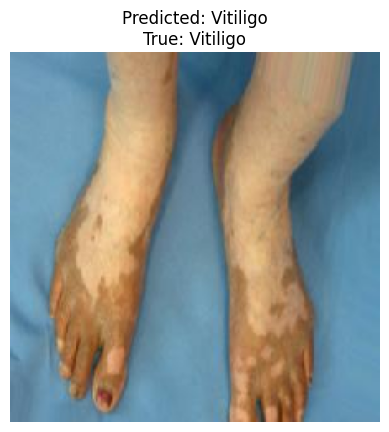

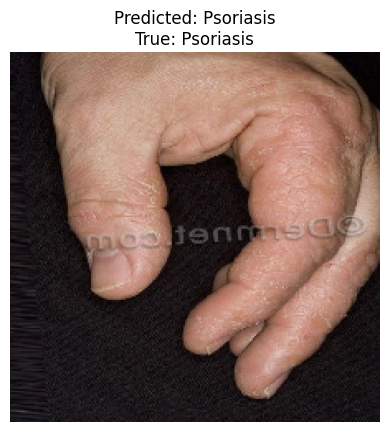

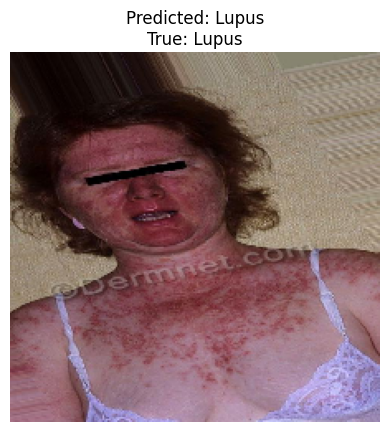

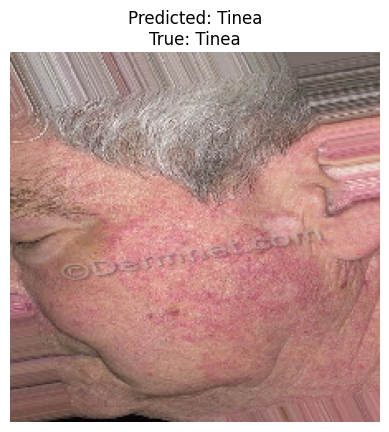

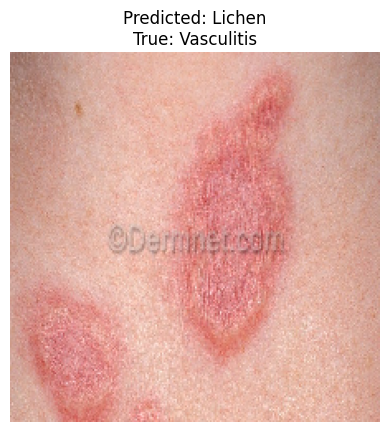

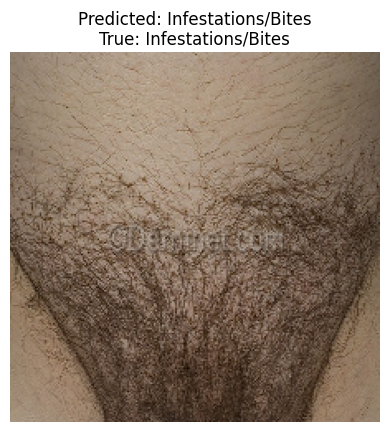

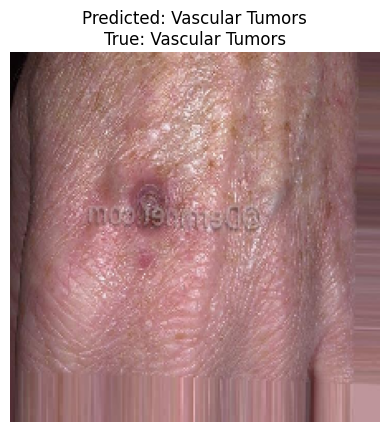

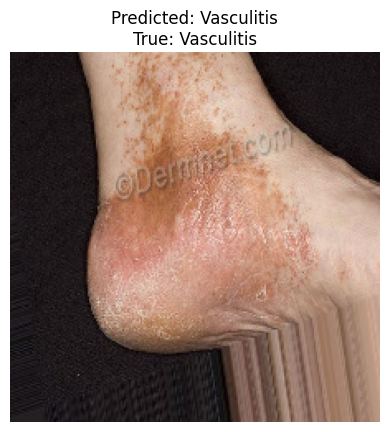

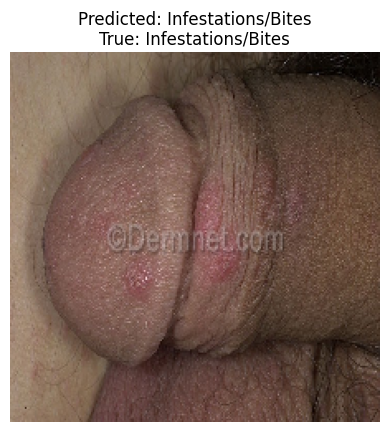

In [ ]:
def predict_and_show(model, generator, class_names, num_images=5):
    images, labels = next(generator)
    predictions = model.predict(images[:num_images])
    for i in range(num_images):
        plt.imshow(images[i])
        plt.title(f"Predicted: {class_names[np.argmax(predictions[i])]}\nTrue: {class_names[np.argmax(labels[i])]}" )
        plt.axis('off')
        plt.show()

predict_and_show(model, test_generator, classes, num_images=10)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Accuracy on the test set: {test_accuracy * 100:.2f}%")

350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.8375 - loss: 0.6789
Accuracy on the test set: 84.09%


In [ ]:
test_generator.reset()
preds = model.predict(test_generator, verbose=0)
preds = np.argmax(preds, axis=1)

cm = confusion_matrix(test_generator.classes, preds)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds,
    target_names=classes,
    digits=4
))

Confusion Matrix:
[[14 19 39 32 22 28 38 22 17 23 35 26 20 29 31 16 29 29 28 29 26]
 [25 13 39 28 20 27 43 33 24 24 21 18 25 19 31 33 22 29 24 17 22]
 [22 34 33 27 25 21 36 29 17 26 29 30 28 17 20 30 25 24 25 26 23]
 [31 11 41 25 24 15 38 25 25 22 25 35 16 21 22 18 30 23 29 23 29]
 [32 17 35 27 26 16 35 27 12 33 25 20 23 22 28 22 30 19 23 16 29]
 [22 22 32 25 24 32 40 37 18 17 27 30 24 27 28 18 23 24 26 21 34]
 [25 20 27 20 21 34 38 39 14 23 32 18 26 23 25 19 28 30 20 30 34]
 [31 22 34 30 20 19 42 25 15 30 18 19 28 17 28 20 27 22 24 28 29]
 [24 22 37 22 25 30 43 24 14 19 20 31 24 17 37 19 28 25 30 26 13]
 [27 13 28 25 27 26 30 18 12 23 24 24 21 24 36 23 23 28 36 18 30]
 [26 19 26 19 21 39 37 25 15 15 25 29 29 19 17 28 22 36 24 29 24]
 [20  7 39 20 30 34 32 28 18 41 18 28 28 22 28 16 28 23 32 21 25]
 [21 19 25 23 28 40 39 34 14 16 20 22 28 18 25 21 36 27 25 22 21]
 [28 21 29 20 11 24 37 18 15 19 21 31 31 25 31 25 24 28 27 28 33]
 [29 16 34 38 23 30 39 29 25 19 24 23 25 26 24 20 29 16 25